# Tweets sentiment analysis

### Importing the libraries

In [1]:
import random
from numpy.random import seed
import tensorflow as tf
import time
#SEED = 32
SEED = int(time.time())
random.seed(SEED)
seed(SEED)
tf.random.set_seed(SEED)

2022-05-21 14:47:52.760010: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import random
import cv2
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, RMSprop
from keras import regularizers
from keras.layers import GaussianNoise

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

#MANAGEMENT PURPOSES ONLY-
from tqdm.notebook import tqdm
import gc
gc.collect()

0

### Load data

In [4]:
data_filepath = 'data'
images_filenames = [x[2] for x in os.walk(os.path.join(data_filepath, 'profile_matrices'))][0]


In [5]:
X = []
for i in range(len(images_filenames)):
    X.append(np.load(os.path.join(data_filepath, 'profile_matrices', str(i)+'.npy')))

In [6]:
y = np.load('./data/y.npy')

In [7]:
y

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,

In [8]:
X[0].shape

(200, 768)

In [9]:
len(X)

420

In [10]:
len(y)

420

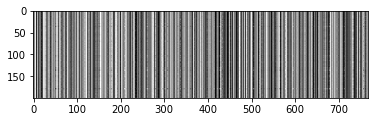

In [11]:
plt.imshow(X[0], cmap='gray')

In [12]:
def one_hot_encode(y, n_classes=2):
    y_one_hot = np.zeros((len(y), n_classes))
    for i in range(len(y)):
        y_one_hot[i, y[i]] = 1
    return y_one_hot

In [13]:
#y = one_hot_encode(y)

In [14]:
X[0].shape

(200, 768)

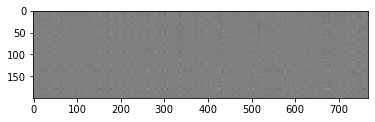

In [15]:
plt.imshow(X[0]-X[1], cmap='gray')

In [16]:
#plt.imshow(resize_image((X[0]-X[326])[0], desired_size=20)[0], cmap='gray')

### Create dataset

In [17]:
permutation_probability = 1.0
def permutate_and_random_cutout(input_img):
    img = input_img.copy()
    if random.random() < permutation_probability:
        img = np.random.permutation(input_img)
    return img

Inputs need to have 3 channels for ImageDataGenerator to work

In [18]:
filter_shape = (3,1)
def CBN(model,filters,ishape=0):
    if (ishape!=0):
        model.add(Conv2D(filters, filter_shape, padding='same',
                         input_shape=ishape))
    else:
        model.add(Conv2D(filters, filter_shape, padding='same'))

    #model.add(Conv2D(filters/2, filter_shape, padding='same'))

    model.add(BatchNormalization())
    #model.add(GaussianNoise(0.3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    return model

In [19]:
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
min_lr = 1e-8
EPOCHS = 50

In [20]:
sgd = SGD()
adam = Adam()
rmsprop = RMSprop()

num_classes = 2

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=min_lr)

In [21]:
def build_model(input_shape):
    model = Sequential()

    model=CBN(model,32,input_shape)
    model=CBN(model,64)
    model=CBN(model,128)
    model=CBN(model,256)
    model=CBN(model,512)

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    model.summary()

    # checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
    
    return model

In [22]:
def to_3_channels_np(a):
    #a = [resize_image(x) for x in a]
    a = [np.repeat(x.reshape(x.shape[0], x.shape[1], 1), 3, axis=2) for x in a]
    a = np.array(a)
    return a

In [23]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    #horizontal_flip = True,
    preprocessing_function=permutate_and_random_cutout)

In [24]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = to_3_channels_np(X_train)
X_test = to_3_channels_np(X_test)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [25]:
print(X_train.shape[1:])

(200, 768, 3)


In [26]:
X_train[0].shape[0]

200

In [27]:
X_train.shape[1:]

(200, 768, 3)

In [29]:
model = build_model(X_train.shape[1:])

history=model.fit(X_train, y_train,
                  steps_per_epoch=len(X_train) / BATCH_SIZE, 
                  epochs=EPOCHS,
                  validation_data=(X_test, y_test),
                  callbacks=[reduce_lr],
                  verbose=1)

## TEST
scores = model.evaluate(X_test, y_test, verbose=1)

2022-05-21 13:55:39.115340: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-21 13:55:39.115864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-21 13:55:39.182854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 13:55:39.183067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:26:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-21 13:55:39.183089: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-21 13:55:39.184500: I tensorflow/stream_executor/platf

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 768, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 768, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 768, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 384, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 384, 64)      6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 384, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 384, 64)      0

2022-05-21 13:55:39.848801: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-21 13:55:39.864823: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601025000 Hz


Epoch 1/50


2022-05-21 13:55:40.287855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-21 13:55:40.414864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


378/378 [==============================] - 5s 11ms/step - loss: 17.7210 - accuracy: 0.4964 - val_loss: 0.6488 - val_accuracy: 0.6190
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.8039 - accuracy: 0.5725 - val_loss: 0.7321 - val_accuracy: 0.5714
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.8094 - accuracy: 0.5490 - val_loss: 0.6296 - val_accuracy: 0.6667
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.8080 - accuracy: 0.5912 - val_loss: 0.6416 - val_accuracy: 0.6429
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6387 - accuracy: 0.5630 - val_loss: 0.6697 - val_accuracy: 0.5952
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 1.0700 - accuracy: 0.5220 - val_loss: 46.0500 - val_accuracy: 0.4286
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6390 - accuracy: 0.5944 - val_loss: 0.6814 - val_accuracy: 0.5952
Epoch 8/

In [30]:
scores

[0.6452401280403137, 0.6428571343421936]

In [31]:
folds = 10
kfold = StratifiedKFold(n_splits=folds, shuffle=True)
X = np.array(X)
y = np.array(y)
cv_accuracies = []
for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"Training fold {index+1}/{folds}")
    X_train, X_test = X[train_indices], X[val_indices]
    y_train, y_test = y[train_indices], y[val_indices]
    
    X_train = to_3_channels_np(X_train)
    X_test = to_3_channels_np(X_test)
    y_train = np.array(one_hot_encode(y_train))
    y_test = np.array(one_hot_encode(y_test))
    
    model = build_model(X_train.shape[1:])
    
    history=model.fit(datagen.flow(X_train, y_train,batch_size=BATCH_SIZE),
                      steps_per_epoch=len(X_train) / BATCH_SIZE, 
                      epochs=EPOCHS,
                      validation_data=(X_test, y_test),
                      callbacks=[reduce_lr],
                      verbose=1)

    ## TEST
    scores = model.evaluate(X_test, y_test, verbose=1)
    cv_accuracies.append(scores[1])
    
    del X_train
    del X_test
    del y_train
    del y_test
    gc.collect()
print(np.mean(cv_accuracies), "+/-", np.std(cv_accuracies))

Training fold 1/10
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 200, 768, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 768, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 200, 768, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 384, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 384, 64)      6208      
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 384, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None,

378/378 [==============================] - 4s 11ms/step - loss: 0.6067 - accuracy: 0.6655 - val_loss: 0.6648 - val_accuracy: 0.5714
Epoch 31/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6589 - accuracy: 0.6058 - val_loss: 0.6620 - val_accuracy: 0.5714
Epoch 32/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6656 - accuracy: 0.6209 - val_loss: 0.6608 - val_accuracy: 0.5952
Epoch 33/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6475 - accuracy: 0.5807 - val_loss: 0.6584 - val_accuracy: 0.5714
Epoch 34/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6513 - accuracy: 0.5941 - val_loss: 0.6581 - val_accuracy: 0.5714
Epoch 35/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6261 - accuracy: 0.6306 - val_loss: 0.6548 - val_accuracy: 0.5714
Epoch 36/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6464 - accuracy: 0.6203 - val_loss: 0.6543 - val_accuracy: 0.5714
Epoc

Epoch 9/50
378/378 [==============================] - 4s 11ms/step - loss: 0.7189 - accuracy: 0.5293 - val_loss: 0.8374 - val_accuracy: 0.4286
Epoch 10/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6922 - accuracy: 0.5409 - val_loss: 0.8332 - val_accuracy: 0.4048
Epoch 11/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7383 - accuracy: 0.5184 - val_loss: 0.8310 - val_accuracy: 0.4048
Epoch 12/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7063 - accuracy: 0.5494 - val_loss: 0.8277 - val_accuracy: 0.4048
Epoch 13/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7255 - accuracy: 0.4935 - val_loss: 0.8274 - val_accuracy: 0.4048
Epoch 14/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6932 - accuracy: 0.5327 - val_loss: 0.8277 - val_accuracy: 0.4048
Epoch 15/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7343 - accuracy: 0.4886 - val_loss: 0.8269 - val_accuracy: 

378/378 [==============================] - 4s 11ms/step - loss: 0.6958 - accuracy: 0.5702 - val_loss: 0.7222 - val_accuracy: 0.5000
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7215 - accuracy: 0.5073 - val_loss: 0.6894 - val_accuracy: 0.5952
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7271 - accuracy: 0.5197 - val_loss: 0.6846 - val_accuracy: 0.5952
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6667 - accuracy: 0.5973 - val_loss: 0.6823 - val_accuracy: 0.5952
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7065 - accuracy: 0.5738 - val_loss: 0.6793 - val_accuracy: 0.5952
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7035 - accuracy: 0.5615 - val_loss: 0.6758 - val_accuracy: 0.5952
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6873 - accuracy: 0.5724 - val_loss: 0.6718 - val_accuracy: 0.6190
Epoch 8/50

378/378 [==============================] - 4s 11ms/step - loss: 0.8004 - accuracy: 0.4799 - val_loss: 0.6990 - val_accuracy: 0.4762
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6981 - accuracy: 0.5548 - val_loss: 0.6966 - val_accuracy: 0.5476
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6964 - accuracy: 0.5757 - val_loss: 0.6885 - val_accuracy: 0.5952
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6654 - accuracy: 0.5986 - val_loss: 0.6875 - val_accuracy: 0.5714
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7052 - accuracy: 0.5761 - val_loss: 0.6859 - val_accuracy: 0.5714
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6783 - accuracy: 0.5942 - val_loss: 0.6846 - val_accuracy: 0.5714
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6590 - accuracy: 0.6343 - val_loss: 0.6856 - val_accuracy: 0.5714
Epoch 8/50

378/378 [==============================] - 4s 11ms/step - loss: 0.7524 - accuracy: 0.4157 - val_loss: 0.6695 - val_accuracy: 0.5952
Epoch 2/50
378/378 [==============================] - 4s 11ms/step - loss: 0.7211 - accuracy: 0.4770 - val_loss: 0.6569 - val_accuracy: 0.5476
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7109 - accuracy: 0.5247 - val_loss: 0.6676 - val_accuracy: 0.5476
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7331 - accuracy: 0.4680 - val_loss: 0.6665 - val_accuracy: 0.5238
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7104 - accuracy: 0.5238 - val_loss: 0.6649 - val_accuracy: 0.5238
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7034 - accuracy: 0.5473 - val_loss: 0.6649 - val_accuracy: 0.5476
Epoch 7/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6754 - accuracy: 0.5774 - val_loss: 0.6638 - val_accuracy: 0.5476
Epoch 8/50

378/378 [==============================] - 4s 11ms/step - loss: 0.8430 - accuracy: 0.5265 - val_loss: 0.7377 - val_accuracy: 0.4762
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7196 - accuracy: 0.5300 - val_loss: 0.7346 - val_accuracy: 0.5952
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7109 - accuracy: 0.5019 - val_loss: 0.7114 - val_accuracy: 0.5714
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6811 - accuracy: 0.5610 - val_loss: 0.7101 - val_accuracy: 0.5714
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7345 - accuracy: 0.4765 - val_loss: 0.7049 - val_accuracy: 0.6190
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7081 - accuracy: 0.5038 - val_loss: 0.7019 - val_accuracy: 0.6190
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7002 - accuracy: 0.5094 - val_loss: 0.6985 - val_accuracy: 0.6190
Epoch 8/50

378/378 [==============================] - 4s 11ms/step - loss: 0.8945 - accuracy: 0.4917 - val_loss: 0.7840 - val_accuracy: 0.5000
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7535 - accuracy: 0.4749 - val_loss: 0.6554 - val_accuracy: 0.6429
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7510 - accuracy: 0.4748 - val_loss: 0.6520 - val_accuracy: 0.5714
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7276 - accuracy: 0.4992 - val_loss: 0.6506 - val_accuracy: 0.5714
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7325 - accuracy: 0.4647 - val_loss: 0.6463 - val_accuracy: 0.5476
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7094 - accuracy: 0.4995 - val_loss: 0.6480 - val_accuracy: 0.5714
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7195 - accuracy: 0.5129 - val_loss: 0.6481 - val_accuracy: 0.5952
Epoch 8/50

378/378 [==============================] - 4s 11ms/step - loss: 0.7487 - accuracy: 0.5531 - val_loss: 0.7458 - val_accuracy: 0.4048
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7545 - accuracy: 0.4679 - val_loss: 0.7023 - val_accuracy: 0.5476
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7125 - accuracy: 0.5129 - val_loss: 0.6944 - val_accuracy: 0.5476
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7401 - accuracy: 0.4558 - val_loss: 0.6917 - val_accuracy: 0.5476
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7200 - accuracy: 0.5214 - val_loss: 0.6888 - val_accuracy: 0.5476
Epoch 6/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7010 - accuracy: 0.5322 - val_loss: 0.6870 - val_accuracy: 0.5476
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7289 - accuracy: 0.5206 - val_loss: 0.6828 - val_accuracy: 0.5476
Epoch 8/50

378/378 [==============================] - 5s 11ms/step - loss: 0.6947 - accuracy: 0.5792 - val_loss: 0.7094 - val_accuracy: 0.5000
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7151 - accuracy: 0.4961 - val_loss: 0.7058 - val_accuracy: 0.5000
Epoch 3/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6992 - accuracy: 0.5644 - val_loss: 0.6978 - val_accuracy: 0.4762
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7023 - accuracy: 0.5424 - val_loss: 0.6964 - val_accuracy: 0.4762
Epoch 5/50
378/378 [==============================] - 4s 11ms/step - loss: 0.7153 - accuracy: 0.5268 - val_loss: 0.6906 - val_accuracy: 0.4762
Epoch 6/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6858 - accuracy: 0.5808 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 7/50
378/378 [==============================] - 4s 11ms/step - loss: 0.6828 - accuracy: 0.5834 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 8/50

378/378 [==============================] - 4s 10ms/step - loss: 0.8377 - accuracy: 0.5117 - val_loss: 0.8745 - val_accuracy: 0.5000
Epoch 2/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7306 - accuracy: 0.5275 - val_loss: 0.6897 - val_accuracy: 0.5476
Epoch 3/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7443 - accuracy: 0.4660 - val_loss: 0.6693 - val_accuracy: 0.5476
Epoch 4/50
378/378 [==============================] - 4s 10ms/step - loss: 0.7089 - accuracy: 0.5254 - val_loss: 0.6666 - val_accuracy: 0.5714
Epoch 5/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6903 - accuracy: 0.5116 - val_loss: 0.6606 - val_accuracy: 0.5952
Epoch 6/50
378/378 [==============================] - 4s 9ms/step - loss: 0.6868 - accuracy: 0.5756 - val_loss: 0.6580 - val_accuracy: 0.6429
Epoch 7/50
378/378 [==============================] - 4s 10ms/step - loss: 0.6765 - accuracy: 0.5721 - val_loss: 0.6563 - val_accuracy: 0.6429
Epoch 8/50


In [32]:
cv_accuracies

[0.6428571343421936,
 0.4285714328289032,
 0.6904761791229248,
 0.5476190447807312,
 0.6666666865348816,
 0.7142857313156128,
 0.7142857313156128,
 0.6666666865348816,
 0.6190476417541504,
 0.761904776096344]

In [28]:
X_train = to_3_channels_np(np.array(X))
y_train = to_categorical(np.array(y), num_classes=num_classes)
model = build_model(X_train.shape[1:])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 768, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 768, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 768, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 384, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 384, 64)      6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 384, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 384, 64)      0

2022-05-21 14:48:20.085893: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-21 14:48:20.086462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-21 14:48:20.147680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 14:48:20.147832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:26:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-21 14:48:20.147846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-21 14:48:20.148738: I tensorflow/stream_executor/platf

In [29]:
len(X_train)

420

In [30]:
def scheduler(epoch):
    return 0.1 * (0.5 ** (epoch // 20))

In [32]:
history=model.fit(X_train, y_train,
                  steps_per_epoch=len(X_train) / BATCH_SIZE, 
                  epochs=EPOCHS,
                  callbacks=[LRS(scheduler)],
                  verbose=1)

2022-05-21 14:49:57.829971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-21 14:49:57.844489: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601025000 Hz


Epoch 1/50


2022-05-21 14:49:58.256036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-21 14:49:58.390736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-21 14:49:58.918573: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-05-21 14:49:58.922309: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at tmp/ipykernel_8329/1888516637.py:1) ]] [Op:__inference_train_function_1775]

Function call stack:
train_function
